# fitting logistic regression models

In [2]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

## cleaning up text

In [3]:
def combine_content(df):
    return (df.assign(content=df['title'] + '\n' + df['text'])
            .drop(columns=['title', 'text']))

def lowercase(df):
    return df.assign(content=df['content'].str.lower())

df = (pd.read_csv('fake_news.csv')
      .fillna('')
      .pipe(combine_content)
      .pipe(lowercase)
     )
df

,baseurl,label,content
0,dailybuzzlive.com,fake,cannibals arrested in florida claim eating hum...
1,houstonchronicle-tv.com,fake,breaking: trump fires deputy attorney general ...
2,higherperspectives.com,fake,keanu reeves shook the world with another powe...
...,...,...,...
824,msnbc.msn.com,real,"oct. 11: levin, graham, mccaffrey, myers, roun..."
825,foxnews.com,real,an open letter to 'all barack channel' - greta...
826,whitehouse.gov,real,state of the union 2013\nthe state of the unio...


## train-test split

In [4]:
from sklearn.model_selection import train_test_split

X = df[['baseurl', 'content']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)
X_train

,baseurl,content
529,twitter.com,\njavascript is not available.\n\nwe’ve detect...
596,whitehouse.gov,remarks by the president at campaign event -- ...
396,web.archive.org,the committee on energy and commerce\nbarton: ...
...,...,...
270,politico.com,full text: jeff flake on trump speech transcri...
435,pol.moveon.org,moveon.org political action: 10 things to know...
102,uspostman.com,"uspostman.com is for sale\nyes, you can transf..."


In [7]:
training_set = X_train.assign(label=y_train)
training_set.to_csv('fake_news_training.csv', index=False)

## tf-idf

takes about 15 seconds to run:

In [4]:
%%time

import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = set(nltk.corpus.stopwords.words('english'))
porter_stemmer = PorterStemmer()

def stemming_tokenizer(document):
    return [porter_stemmer.stem(word)
            for word in nltk.word_tokenize(document)
            if word not in stop_words]
    return words

tfidf = TfidfVectorizer(tokenizer=stemming_tokenizer)
article_vectors = tfidf.fit_transform(X_train['content'])
article_vectors.shape

CPU times: user 14.4 s, sys: 203 ms, total: 14.6 s
Wall time: 15.7 s


(661, 27904)

## pca

In [5]:
from scipy.sparse.linalg import svds

def compute_pcs(data, k):
    centered = data - data.mean(axis=0)
    U, s, Vt = svds(centered, k=k)
    return U @ np.diag(s)

# Setting the random seed doesn't affect svds(), so re-running this code
# might flip the points along the x or y-axes.
pcs = compute_pcs(article_vectors, k=2)

# So we'll use a hack: we make sure the first row's PCs are both positive to get
# the same plot each time.
if pcs[0, 0] < 0:
    pcs[:, 0] *= -1
if pcs[0, 1] < 0:
    pcs[:, 1] *= -1

with_pcs1 = X_train.assign(pc1=pcs[:, 0], pc2=pcs[:, 1]).assign(label=y_train)
with_pcs1

,baseurl,content,pc1,pc2,label
529,twitter.com,\njavascript is not available.\n\nwe’ve detect...,0.07,0.30,real
596,whitehouse.gov,remarks by the president at campaign event -- ...,-0.14,-0.44,real
396,web.archive.org,the committee on energy and commerce\nbarton: ...,-0.12,-0.13,real
...,...,...,...,...,...
270,politico.com,full text: jeff flake on trump speech transcri...,0.12,-0.30,fake
435,pol.moveon.org,moveon.org political action: 10 things to know...,-0.16,-0.14,real
102,uspostman.com,"uspostman.com is for sale\nyes, you can transf...",-0.01,0.20,fake


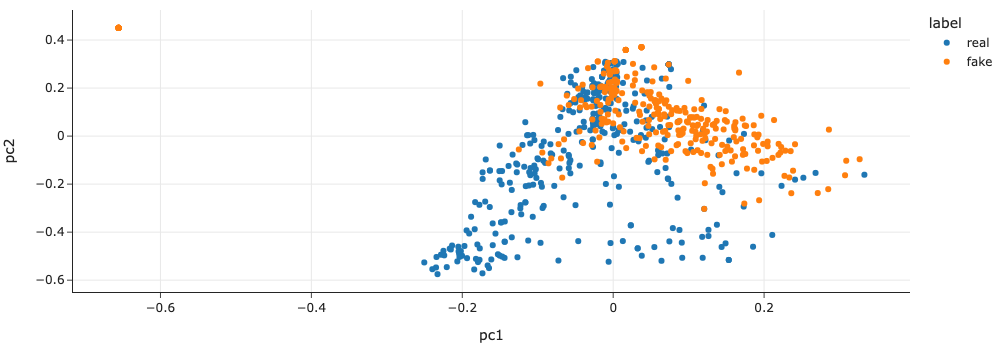

In [6]:
fig = px.scatter(with_pcs1, x='pc1', y='pc2',
                 color='label',
                 hover_data=['baseurl'],
                 width=550, height=350)
fig

## log reg using tf-idf

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [8]:
X_train

,baseurl,content
529,twitter.com,\njavascript is not available.\n\nwe’ve detect...
596,whitehouse.gov,remarks by the president at campaign event -- ...
396,web.archive.org,the committee on energy and commerce\nbarton: ...
...,...,...
270,politico.com,full text: jeff flake on trump speech transcri...
435,pol.moveon.org,moveon.org political action: 10 things to know...
102,uspostman.com,"uspostman.com is for sale\nyes, you can transf..."


In [25]:
clf = make_pipeline(
    make_column_transformer((tfidf, 'content')),
    LogisticRegressionCV(Cs=10,
                         solver='saga',
                         n_jobs=4,
                         max_iter=1000),
)

takes about 30 seconds to run:

In [26]:
%%time

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

CPU times: user 35.6 s, sys: 200 ms, total: 35.8 s
Wall time: 25.2 s


0.9036144578313253

confusion matrix

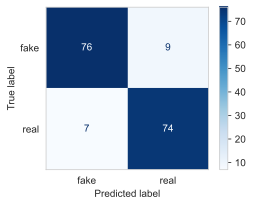

In [30]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test,
                      cmap=plt.cm.Blues)
plt.grid(False);

In [31]:
log_reg = clf.named_steps['logisticregressioncv']
log_reg.Cs_

array([    0.  ,     0.  ,     0.01,     0.05,     0.36,     2.78,
          21.54,   166.81,  1291.55, 10000.  ])

In [32]:
coefs = (pd.DataFrame(tfidf.vocabulary_.keys(),
                      columns=['word'],
                      index=tfidf.vocabulary_.values())
         .sort_index()
         .assign(coef=log_reg.coef_[0])
        )
coefs
# coef = np.abs(clf.coef_)

,word,coef
0,!,-7.74
1,#,-1.47
2,$,-2.16
...,...,...
27901,日新丸,-0.16
27902,澳门老百汇4001登录,-1.79
27903,﻿,-0.37


In [13]:
df_interact(coefs.query('coef < -0.5 or coef > 0.5').sort_values('coef'))

interactive(children=(IntSlider(value=0, description='row', max=3799, step=7), Output()), _dom_classes=('widge…

(3799 rows, 2 columns) total


## log reg using one word feature

In [33]:
word_features = [
    'trump',
]

In [34]:
def make_word_features(df, words=word_features):
    features = { word: df['content'].str.contains(word) for word in words }
    return pd.DataFrame(features)

In [35]:
from sklearn.preprocessing import FunctionTransformer

clf = make_pipeline(
    FunctionTransformer(make_word_features, kw_args={'words': word_features}),
    LogisticRegressionCV(Cs=10,
                         solver='saga',
                         n_jobs=4,
                         max_iter=10000)
)

In [36]:
%%time

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.6325301204819277
CPU times: user 70.8 ms, sys: 11.5 ms, total: 82.4 ms
Wall time: 58.2 ms


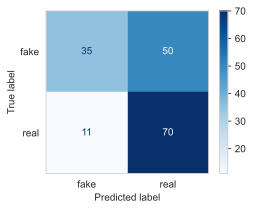

In [37]:
plot_confusion_matrix(clf, X_test, y_test,
                      cmap=plt.cm.Blues)
plt.grid(False);

In [39]:
log_reg = clf.named_steps['logisticregressioncv']
log_reg.Cs_

array([    0.  ,     0.  ,     0.01,     0.05,     0.36,     2.78,
          21.54,   166.81,  1291.55, 10000.  ])

In [40]:
coefs = (pd.DataFrame({'word': word_features, 'coef': log_reg.coef_[0]})
         .set_index('word')
         .sort_values('coef')
        )
coefs

,coef
word,
trump,-0.92


## log reg with multiple word features

In [41]:
word_features = [
    'military',
    'state',
    'vote',
    'congress',
    'fbi',
    'shutdown',
    'investig',
    'antifa',

    'joke',
    'princ',
    'homeless',
    'cnn',

    'trump',
    'donald',
    'hillary',
    'clinton'
]

In [42]:
clf = make_pipeline(
    FunctionTransformer(make_word_features, kw_args={'words': word_features}),
    LogisticRegressionCV(Cs=10,
                         solver='saga',
                         n_jobs=4,
                         max_iter=10000)
)

In [43]:
%%time

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.7409638554216867
CPU times: user 1.65 s, sys: 9.73 ms, total: 1.66 s
Wall time: 616 ms


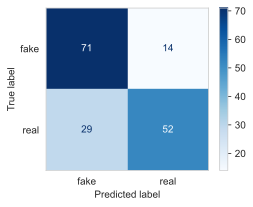

In [45]:
plot_confusion_matrix(clf, X_test, y_test,
                      cmap=plt.cm.Blues)
plt.grid(False);

In [46]:
log_reg = clf.named_steps['logisticregressioncv']
log_reg.Cs_

array([    0.  ,     0.  ,     0.01,     0.05,     0.36,     2.78,
          21.54,   166.81,  1291.55, 10000.  ])

In [47]:
coefs = (pd.DataFrame({'word': word_features, 'coef': log_reg.coef_[0]})
         .set_index('word')
         .sort_values('coef')
        )
display_df(coefs, 16)

,coef
word,
trump,-2.28
joke,-1.39
antifa,-0.98
investig,-0.79
fbi,-0.71
donald,-0.37
cnn,-0.26
state,0.13
clinton,0.13
